# Experiments simulation 2


## Imports

In [2]:
import os, sys, random, pickle
from datetime import datetime
from zoneinfo import ZoneInfo  
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.manifold import MDS
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from PyDistances.mixed import FastGGowerDistMatrix
sns.set_style('whitegrid')

current_path = os.getcwd()
src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')
sys.path.append(src_path)
sys.path.append(config_path)

from simulations_utils import get_simulation_3

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names, 
                               split_list_in_chunks)

from config_experiment_1_simulation_3 import get_config as get_config_exp_1_sim_3
from config_experiment_3_simulation_3 import get_config as get_config_exp_3_sim_3
from config_experiment_4_simulation_3 import get_config as get_config_exp_4_sim_3


## Data Simulation

In [3]:
X, y, outliers_idx = get_simulation_3(random_state=123, return_outlier_idx=True)

In [4]:
# polars conversion for data exploration
X_pl = pl.from_pandas(X)

## Data Exploration

In [5]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,6.284108,-2.218508,-6.732578,0.352627,1,0,3,3
1,3.953901,-5.405226,-0.076778,0.958369,0,1,0,1
2,-0.732585,1.007679,1.217141,3.729691,0,0,2,3
3,5.735251,-6.170185,4.437365,-9.121148,0,0,0,2
4,3.597274,-7.497242,1.314502,-2.669496,0,1,0,0


In [6]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


In [7]:
# Outliers information
outliers_table(X_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""X1""",-17.311893,16.827204,4539,95461,0.04539,0.95461
"""X2""",-12.631825,3.882602,5046,94954,0.05046,0.94954
"""X3""",-11.877029,6.497705,116,99884,0.00116,0.99884
"""X4""",-10.228393,11.273816,1364,98636,0.01364,0.98636


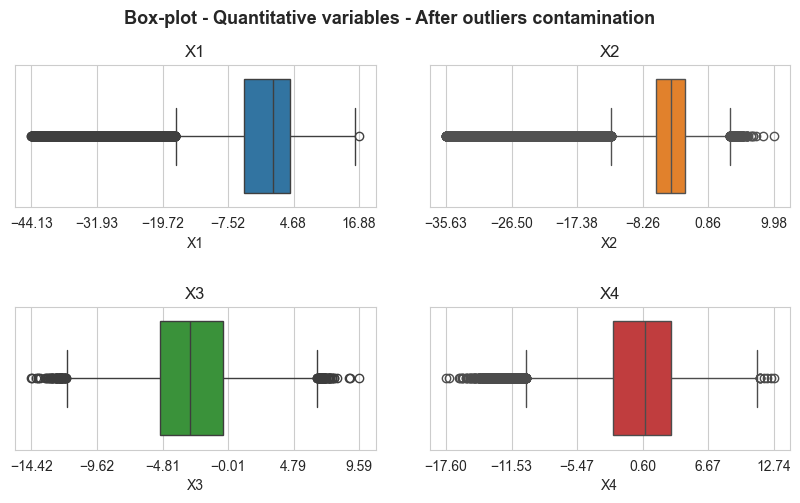

In [8]:
# Boxplot after outliers contamination
boxplot_matrix(X_pl, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

In [9]:
# Boxplot before outliers contamination
'''
boxplot_matrix(X_not_outliers, 
               n_cols=2, 
               title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), 
               quant_col_names=['X1', 'X2', 'X3', 'X4'], 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)
'''

"\nboxplot_matrix(X_not_outliers, \n               n_cols=2, \n               title='Box-plot - Quantitative variables - Before outliers contamination', \n               figsize=(10,5), \n               quant_col_names=['X1', 'X2', 'X3', 'X4'], \n               n_xticks=6, \n               title_fontsize=13, \n               save=False, \n               file_name='', \n               x_rotation=0, \n               title_height=0.99,\n               style='whitegrid', \n               hspace=0.7, \n               wspace=0.15, \n               title_weight='bold',\n               subtitles_fontsize=12, \n               xlabel_size=10)\n"

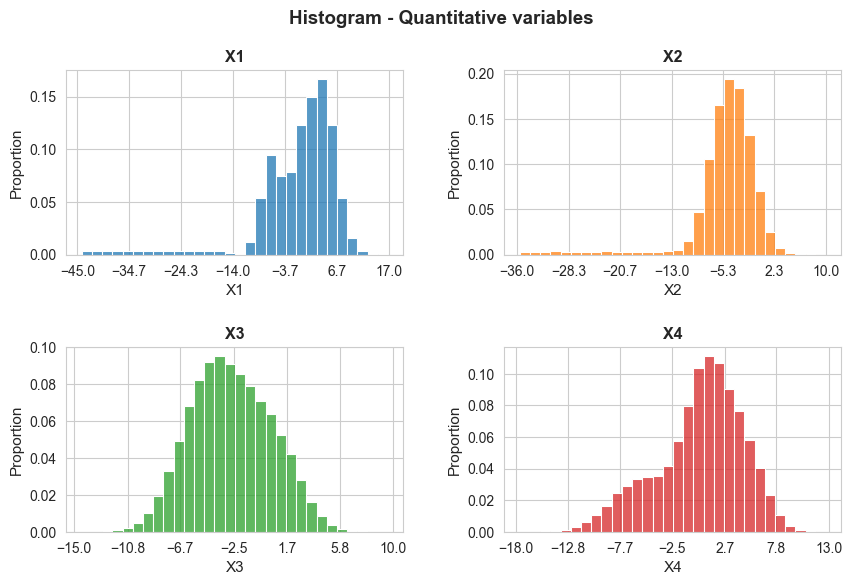

In [10]:
# Histogram
histogram_matrix(df=X_pl, bins=30, n_cols=2, title='Histogram - Quantitative variables', 
                 figsize=(10,6), quant_col_names=['X1', 'X2', 'X3', 'X4'], 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

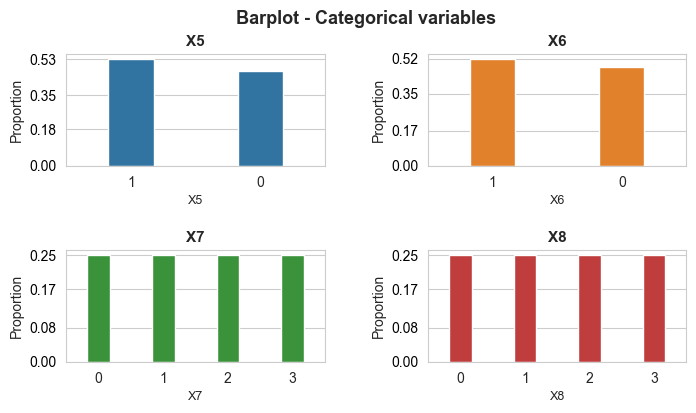

In [11]:
# Barplot
barplot_matrix(df=X_pl, n_cols=2, title='Barplot - Categorical variables', 
                 figsize=(8,4), cat_col_names=['X5', 'X6', 'X7', 'X8'], 
                 title_fontsize=13, subtitles_fontsize=11, 
                 save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.75, wspace=0.4, title_weight='bold', bar_width=0.35,
                 ylabel_size=10, xlabel_size=9, xticks_size=10)

In [12]:
# Correlation Matrix
X[['X1', 'X2', 'X3', 'X4']].corr()

,X1,X2,X3,X4
X1,1.000000,0.788051,-0.290411,-0.180770
X2,0.788051,1.000000,-0.119688,0.042850
X3,-0.290411,-0.119688,1.000000,-0.045632
X4,-0.180770,0.042850,-0.045632,1.000000


In [13]:
# Correlation Analysis
corr_matrix = X[['X1', 'X2', 'X3', 'X4']].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.17
Proportion of pair-wise correlations in [0.30, 0.60]:  0.0
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.83


## Experiment 1: Accuracy and computation time for Fast k-medoids

In [ ]:
run_experiment_1 = False

In [ ]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_1', 'simulation_2')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_1_config = get_config_exp_1_sim_3()

    X, y = get_simulation_3(random_state=experiment_random_state, return_outlier_idx=False)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**experiment_1_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state)
            
        # Save results
        results_filename = f'results_exp_1_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realization 
## Personal computer: 
## IBiDat Server: 635 mins = 10.6 hours

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427]
random_state: 6863
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 35084
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11427
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:   3%|▎         | 1/34 [19:02<10:28:27, 1142.66s/chunks]

random_state_chunk: [53377, 34937, 14116]
random_state: 53377
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 34937
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 14116
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:   6%|▌         | 2/34 [37:58<10:07:17, 1138.67s/chunks]

random_state_chunk: [5000, 49692, 70281]
random_state: 5000
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 49692
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 70281
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:   9%|▉         | 3/34 [57:20<9:53:50, 1149.37s/chunks] 

random_state_chunk: [73704, 43541, 44669]
random_state: 73704
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 43541
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 44669
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  12%|█▏        | 4/34 [1:16:15<9:31:43, 1143.46s/chunks]

random_state_chunk: [6802, 20927, 17702]
random_state: 6802
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 20927
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 17702
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  15%|█▍        | 5/34 [1:34:52<9:08:09, 1134.12s/chunks]

random_state_chunk: [44199, 73526, 43751]
random_state: 44199
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 73526
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 43751
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  18%|█▊        | 6/34 [1:54:04<8:51:59, 1140.00s/chunks]

random_state_chunk: [91971, 32134, 21466]
random_state: 91971
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 32134
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 21466
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  21%|██        | 7/34 [2:13:06<8:33:23, 1140.87s/chunks]

random_state_chunk: [218, 57183, 11483]
random_state: 218
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 57183
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11483
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  24%|██▎       | 8/34 [2:32:08<8:14:31, 1141.20s/chunks]

random_state_chunk: [78328, 49492, 9158]
random_state: 78328
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 49492
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 9158
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  26%|██▋       | 9/34 [2:51:19<7:56:46, 1144.24s/chunks]

random_state_chunk: [864, 41347, 95949]
random_state: 864
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 41347
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 95949
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  29%|██▉       | 10/34 [3:10:39<7:39:36, 1149.00s/chunks]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 13374
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 5752
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  32%|███▏      | 11/34 [3:29:37<7:19:10, 1145.66s/chunks]

random_state_chunk: [12158, 87443, 18635]
random_state: 12158
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 87443
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 18635
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  35%|███▌      | 12/34 [3:48:32<6:58:56, 1142.56s/chunks]

random_state_chunk: [16547, 2783, 38247]
random_state: 16547
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 2783
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 38247
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  38%|███▊      | 13/34 [4:07:29<6:39:18, 1140.89s/chunks]

random_state_chunk: [56444, 75157, 62511]
random_state: 56444
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 75157
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 62511
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  41%|████      | 14/34 [4:27:14<6:24:41, 1154.05s/chunks]

random_state_chunk: [34776, 61511, 4816]
random_state: 34776
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 61511
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 4816
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  44%|████▍     | 15/34 [4:46:18<6:04:33, 1151.25s/chunks]

random_state_chunk: [39989, 45018, 68376]
random_state: 39989
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 45018
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 68376
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  47%|████▋     | 16/34 [5:05:19<5:44:25, 1148.07s/chunks]

random_state_chunk: [63302, 27113, 79810]
random_state: 63302
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 27113
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 79810
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  50%|█████     | 17/34 [5:24:19<5:24:34, 1145.54s/chunks]

random_state_chunk: [83723, 69084, 74031]
random_state: 83723
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 69084
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 74031
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  53%|█████▎    | 18/34 [5:43:23<5:05:24, 1145.26s/chunks]

random_state_chunk: [41322, 1644, 52197]
random_state: 41322
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 1644
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 52197
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  56%|█████▌    | 19/34 [6:02:32<4:46:32, 1146.14s/chunks]

random_state_chunk: [84692, 67207, 56935]
random_state: 84692
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 67207
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 56935
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  59%|█████▉    | 20/34 [6:22:00<4:29:00, 1152.91s/chunks]

random_state_chunk: [89762, 70584, 83670]
random_state: 89762
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 70584
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 83670
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  62%|██████▏   | 21/34 [6:41:31<4:10:58, 1158.34s/chunks]

random_state_chunk: [87380, 78185, 63718]
random_state: 87380
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 78185
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 63718
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  65%|██████▍   | 22/34 [7:00:08<3:49:11, 1145.94s/chunks]

random_state_chunk: [68237, 87617, 54984]
random_state: 68237
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 87617
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 54984
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  68%|██████▊   | 23/34 [7:19:00<3:29:16, 1141.53s/chunks]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 66855
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 4173
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  71%|███████   | 24/34 [7:37:41<3:09:14, 1135.49s/chunks]

random_state_chunk: [98850, 84600, 23784]
random_state: 98850
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 84600
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 23784
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  74%|███████▎  | 25/34 [7:56:57<2:51:15, 1141.77s/chunks]

random_state_chunk: [95135, 10827, 63819]
random_state: 95135
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 10827
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 63819
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  76%|███████▋  | 26/34 [8:15:59<2:32:14, 1141.78s/chunks]

random_state_chunk: [86255, 34326, 22298]
random_state: 86255
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 34326
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 22298
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  79%|███████▉  | 27/34 [8:35:16<2:13:44, 1146.29s/chunks]

random_state_chunk: [43896, 44160, 72640]
random_state: 43896
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 44160
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 72640
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  82%|████████▏ | 28/34 [8:55:05<1:55:53, 1158.97s/chunks]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 9606
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 94779
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  85%|████████▌ | 29/34 [9:13:31<1:35:16, 1143.25s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 50810
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 75126
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  88%|████████▊ | 30/34 [9:32:51<1:16:33, 1148.26s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 2137
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 24780
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  91%|█████████ | 31/34 [9:51:45<57:11, 1143.85s/chunks]  

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 11554
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 82354
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  94%|█████████▍| 32/34 [10:10:42<38:03, 1141.96s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 1681
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2
random_state: 46126
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks:  97%|█████████▋| 33/34 [10:29:24<18:55, 1135.94s/chunks]

random_state_chunk: [30032]
random_state: 30032
frac_sample_size: 0.0005
frac_sample_size: 0.005
frac_sample_size: 0.01
frac_sample_size: 0.05
frac_sample_size: 0.1
frac_sample_size: 0.2


chunks: 100%|██████████| 34/34 [10:35:54<00:00, 1122.19s/chunks]


In [ ]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_chunk = {}
    file_id = '20250714_113600'
    results_folder_path = os.path.join(current_path, '..', '..',  'results', 'results_experiment_1', 'simulation_2')
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_simu_3_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [14]:
# Open merged/joined results 
file_id = '20250714_113600'
results_filename = f'results_exp_1_simu_3_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'simulation_2')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [15]:
experiment_1_config = get_config_exp_1_sim_3()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [16]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

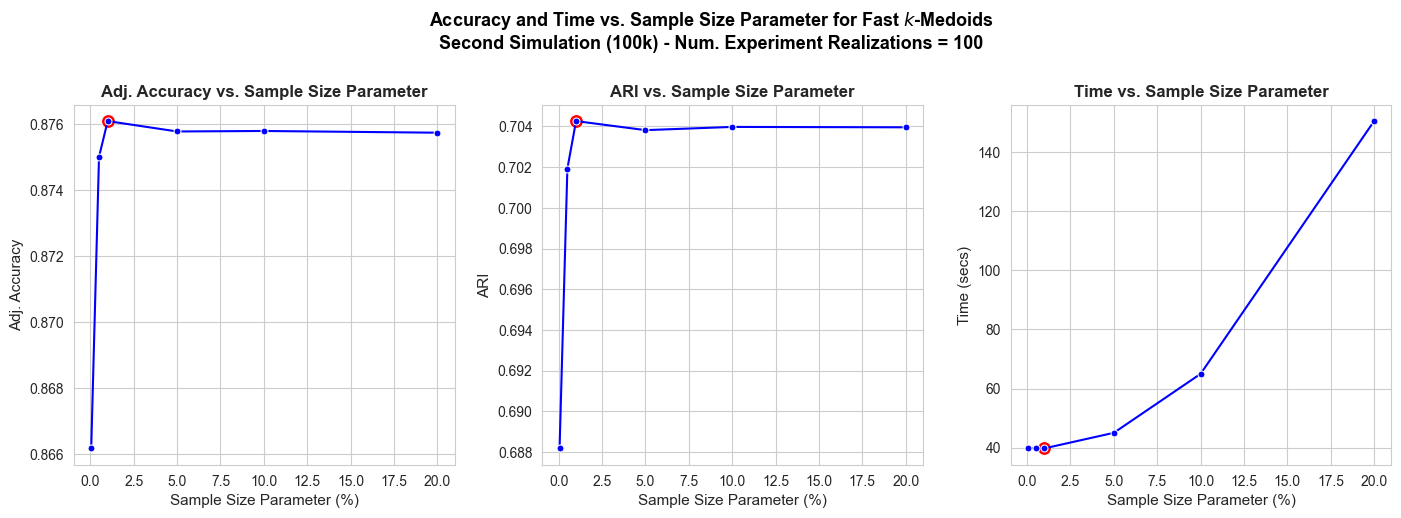

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size Parameter', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size Parameter', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size Parameter', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy and Time vs. Sample Size Parameter for Fast $k$-Medoids\nSecond Simulation (100k) - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_simu_3_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [28]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.0005,39.887744,0.866163,0.688184
0.0050,39.767034,0.875003,0.701925
0.0100,39.766805,0.876086,0.704260
0.0500,45.022848,0.875771,0.703815
0.1000,64.978593,0.875786,0.703973
0.2000,150.532901,0.875734,0.703954


In [29]:
print(best_frac_sample_size)

0.01



## Experiment 3: Accuracy, computation time and number of folds for q-Fold Fast k-medoids 

In [21]:
run_experiment_3 = False

In [ ]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_3', 'simulation_2')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    experiment_3_config = get_config_exp_3_sim_3()

    X, y = get_simulation_3(random_state=experiment_random_state, return_outlier_idx=False)

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**experiment_3_config,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state)

        # Save results
        results_filename = f'results_exp_3_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realization
## IBiDat Server: 1350 mins = 22.5 hours

chunks:   0%|          | 0/6 [00:00<?, ?chunks/s]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.69s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:12<00:00, 14.59s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:42<00:00, 20.58s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.90s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:19<00:00,  4.00s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.12s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.12s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.05s/it]


random_state: 9606
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.69s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:06<00:00, 13.39s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.24s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:49<00:00, 21.82s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:23<00:00,  8.30s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.75s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:32<00:00,  2.31s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:19<00:00,  2.00s/it]


random_state: 94779
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.30s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:07<00:00, 13.54s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:12<00:00, 14.40s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.72s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:21<00:00,  8.15s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:21<00:00,  2.04s/it]


frac_sample_size: 0.25


chunks:  17%|█▋        | 1/6 [1:03:06<5:15:33, 3786.62s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.66s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:06<00:00, 13.22s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:07<00:00, 13.47s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:40<00:00, 20.02s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  7.00s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.57s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:15<00:00,  1.88s/it]


random_state: 50810
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:06<00:00, 13.29s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.07s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:44<00:00, 20.94s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.85s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.69s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.70s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:29<00:00,  2.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:23<00:00,  2.08s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:19<00:00,  1.99s/it]


random_state: 75126
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:06<00:00, 13.33s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:07<00:00, 13.44s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:09<00:00, 13.99s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:43<00:00, 20.76s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.84s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.80s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:29<00:00,  2.25s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


frac_sample_size: 0.25


chunks:  33%|███▎      | 2/6 [2:05:27<4:10:39, 3759.98s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:09<00:00, 13.80s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:13<00:00, 14.68s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:42<00:00, 20.51s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.82s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:23<00:00,  8.33s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:29<00:00,  2.23s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:17<00:00,  1.94s/it]


random_state: 2137
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.65s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:09<00:00, 13.91s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.12s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:48<00:00, 21.79s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it]


random_state: 24780
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.07s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:07<00:00, 13.59s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:12<00:00, 14.50s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:43<00:00, 20.77s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


frac_sample_size: 0.25


chunks:  50%|█████     | 3/6 [3:08:03<3:07:54, 3758.08s/chunks]

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:09<00:00, 13.89s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.28s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.06s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:41<00:00, 20.39s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.97s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:21<00:00,  8.14s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:30<00:00,  2.27s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:20<00:00,  2.02s/it]


random_state: 11554
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.15s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.78s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.39s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:41<00:00, 20.37s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.17s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:18<00:00,  1.97s/it]


random_state: 82354
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.01s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.10s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:13<00:00, 14.68s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:44<00:00, 20.86s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:25<00:00,  8.53s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.90s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.15s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


frac_sample_size: 0.25


chunks:  67%|██████▋   | 4/6 [4:11:17<2:05:43, 3771.99s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:10<00:00, 14.10s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.66s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:13<00:00, 14.78s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:47<00:00, 21.41s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.92s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:22<00:00,  8.24s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:29<00:00,  2.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.13s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.10s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:18<00:00,  1.95s/it]


random_state: 1681
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.66s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.77s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.29s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:44<00:00, 20.94s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:16<00:00,  7.69s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 40/40 [01:20<00:00,  2.00s/it]


random_state: 46126
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:09<00:00, 13.95s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:06<00:00, 13.23s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:12<00:00, 14.52s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:49<00:00, 21.86s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.86s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:27<00:00,  2.18s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:24<00:00,  2.11s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]


frac_sample_size: 0.25


chunks:  83%|████████▎ | 5/6 [5:13:53<1:02:46, 3766.31s/chunks]

random_state_chunk: [30032]
random_state: 30032
n_splits: 5
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.21s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 5/5 [01:08<00:00, 13.70s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 5/5 [01:11<00:00, 14.21s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 5/5 [01:44<00:00, 20.92s/it]


n_splits: 10
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 10/10 [01:08<00:00,  6.89s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 10/10 [01:20<00:00,  8.06s/it]


n_splits: 20
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


frac_sample_size: 0.25


Clustering Folds: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


n_splits: 40
frac_sample_size: 0.005


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.05


Clustering Folds: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


frac_sample_size: 0.1


Clustering Folds: 100%|██████████| 40/40 [01:22<00:00,  2.06s/it]


frac_sample_size: 0.25


chunks: 100%|██████████| 6/6 [5:34:42<00:00, 3347.02s/chunks]  


In [ ]:
if run_experiment_3: 

    # Open results by chunk
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_2')
    chunk_ids = range(len(os.listdir(results_folder_path)))
    results_chunk = {}
    file_id = "20250715_130253"
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_simu_3_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [5]:
# Open merged/joined results 
file_id = "20250715_130253"
results_filename = f'results_exp_3_simu_3_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'simulation_2')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [6]:
experiment_3_config = get_config_exp_3_sim_3()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = experiment_3_config['n_splits'], 
                                  iterable2 = experiment_3_config['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

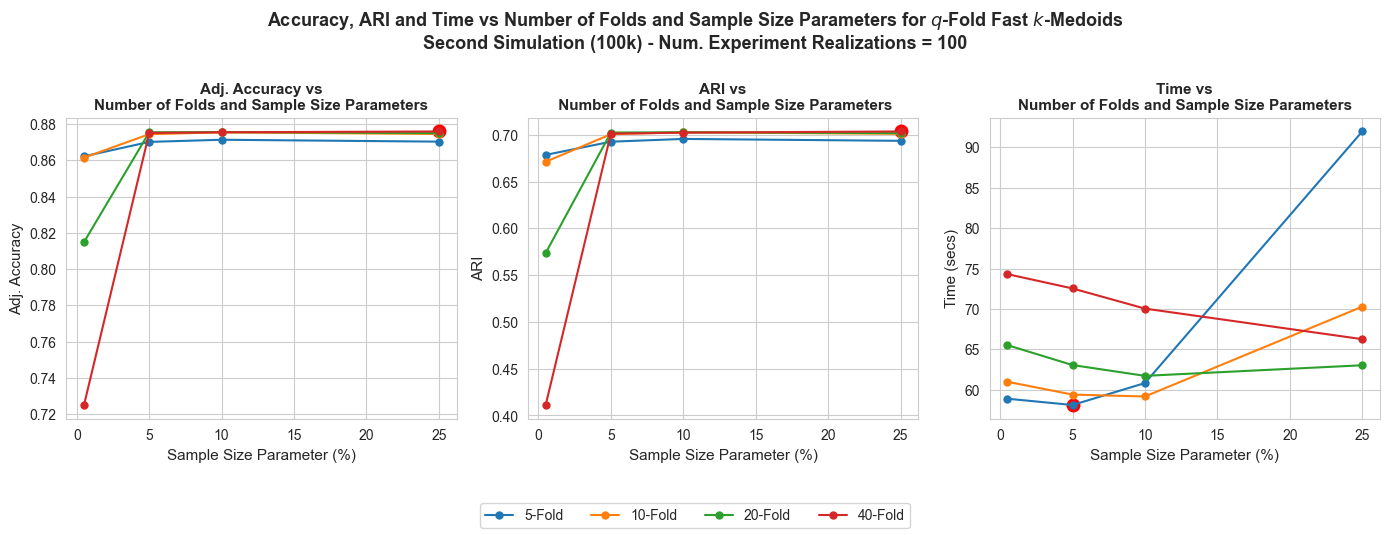

In [7]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\nNumber of Folds and Sample Size Parameters", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs Number of Folds and Sample Size Parameters for $q$-Fold Fast $k$-Medoids\nSecond Simulation (100k) - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_simu_3_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()


In [17]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.005,0.862182,0.678495,58.902261
1,5,0.050,0.870161,0.692600,58.127094
2,5,0.100,0.871348,0.695557,60.840425
3,5,0.250,0.870298,0.693527,91.953765
4,10,0.005,0.861493,0.671184,61.000999
5,10,0.050,0.874413,0.700550,59.413234
6,10,0.100,0.875439,0.702673,59.179105
7,10,0.250,0.874507,0.700998,70.288495
8,20,0.005,0.814911,0.573662,65.529539
9,20,0.050,0.875467,0.702354,63.064743


In [20]:
best_frac_sample_size = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['frac_sample_sizes']
best_n_splits = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]['n_splits']
n = len(X)
split_ratio = np.round((best_n_splits/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_n_splits, '\n', 'best_frac_sample_size', best_frac_sample_size)

 split_ratio 0.04 
 best_n_splits 40.0 
 best_frac_sample_size 0.25


## Experiment 4: Empirical comparison to other existing algorithms 

In [3]:
run_experiment_4 = False

In [7]:
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans
from clustpy.hierarchical import Diana

experiment_4_config = get_config_exp_4_sim_3()

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

models = {
    
    'KMeans': KMeans(
        n_clusters=experiment_4_config['n_clusters'], 
        random_state=experiment_4_config['random_state'], 
        init='k-means++', 
        n_init='auto', 
        max_iter=experiment_4_config['max_iter']),

    'CLARA': CLARA(n_clusters=experiment_4_config['n_clusters'], 
                   metric='euclidean'),

    'LDAKmeans': LDAKmeans(n_clusters=experiment_4_config['n_clusters']),

    'SubKmeans': SubKmeans(n_clusters=experiment_4_config['n_clusters']),

    'GaussianMixture': GaussianMixture(n_components=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state']),

    'SpectralBiclustering': SpectralBiclustering(n_clusters=experiment_4_config['n_clusters']),

    'SpectralCoclustering': SpectralCoclustering(n_clusters=experiment_4_config['n_clusters']),

    'BisectingKMeans': BisectingKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter']),

    'MiniBatchKMeans': MiniBatchKMeans(n_clusters=experiment_4_config['n_clusters'], 
                                       random_state=experiment_4_config['random_state'], 
                                       max_iter=experiment_4_config['max_iter'])
                                       
}

#################################################################################################

for d in GGower_distances_names:

    d1, d2, d3 = d.split('-')

    if 'robust' in d1:
        r = d1.split('_')[-1]
        d1 = '_'.join(d1.split('_')[:2])
        
    models[f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples']) 

    models[f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
            n_clusters=experiment_4_config['n_clusters'], 
            method=experiment_4_config['method'], 
            init=experiment_4_config['init'], 
            max_iter=experiment_4_config['max_iter'], 
            random_state=experiment_4_config['random_state'],
            frac_sample_size=experiment_4_config['frac_sample_size'], 
            p1=experiment_4_config['p1'], 
            p2=experiment_4_config['p2'], 
            p3=experiment_4_config['p3'], 
            d1=d1, 
            d2=d2, 
            d3=d3, 
            robust_method=r, 
            alpha=experiment_4_config['alpha'], 
            epsilon=experiment_4_config['epsilon'], 
            n_iters=experiment_4_config['n_iters'],
            VG_sample_size=experiment_4_config['VG_sample_size'], 
            VG_n_samples=experiment_4_config['VG_n_samples'],
            n_splits=experiment_4_config['n_splits'], 
            shuffle=experiment_4_config['shuffle'], 
            kfold_random_state=experiment_4_config['kfold_random_state']) 

In [ ]:
if run_experiment_4: 
   
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_2')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        

            X, y = get_simulation_3(
                random_state=random_state, 
                return_outlier_idx=False)
            
            results[random_state] = make_experiment_4(
                X=X, 
                y=y, 
                models=models)

        # Save results
        results_filename = f'results_exp_4_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 
## IBiDat Server: 1681 mins =  hours 

In [ ]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_2')
    file_id = '20250717_092545'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_simu_3_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_simu_3_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [5]:
# Open merged/joined results 
file_id = '20250717_092545'
results_filename = f'results_exp_4_simu_3_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'simulation_2')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [8]:
model_names = list(models.keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [9]:
avg_results['std_adj_acc'] = {k: np.std(pivoted_results['adj_accuracy'][k]) for k in model_names}
avg_results['std_ARI'] = {k: np.std(pivoted_results['ARI'][k]) for k in model_names}
avg_results['std_time'] = {k: np.std(pivoted_results['time'][k]) for k in model_names}

In [12]:
not_feasible_methods = ['DipInit', 'Spectral-Clustering', 'KMedoids-euclidean', 'Diana', 'AgglomerativeClustering', 'Birch'] # based on previous (TFM) experiments

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0
    avg_results['std_adj_acc'][model_name] = 0
    avg_results['std_ARI'][model_name] = 0
    avg_results['std_time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
std_adj_acc = np.array(list(avg_results['std_adj_acc'].values()))
std_ari = np.array(list(avg_results['std_ARI'].values()))
std_time = np.array(list(avg_results['std_time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

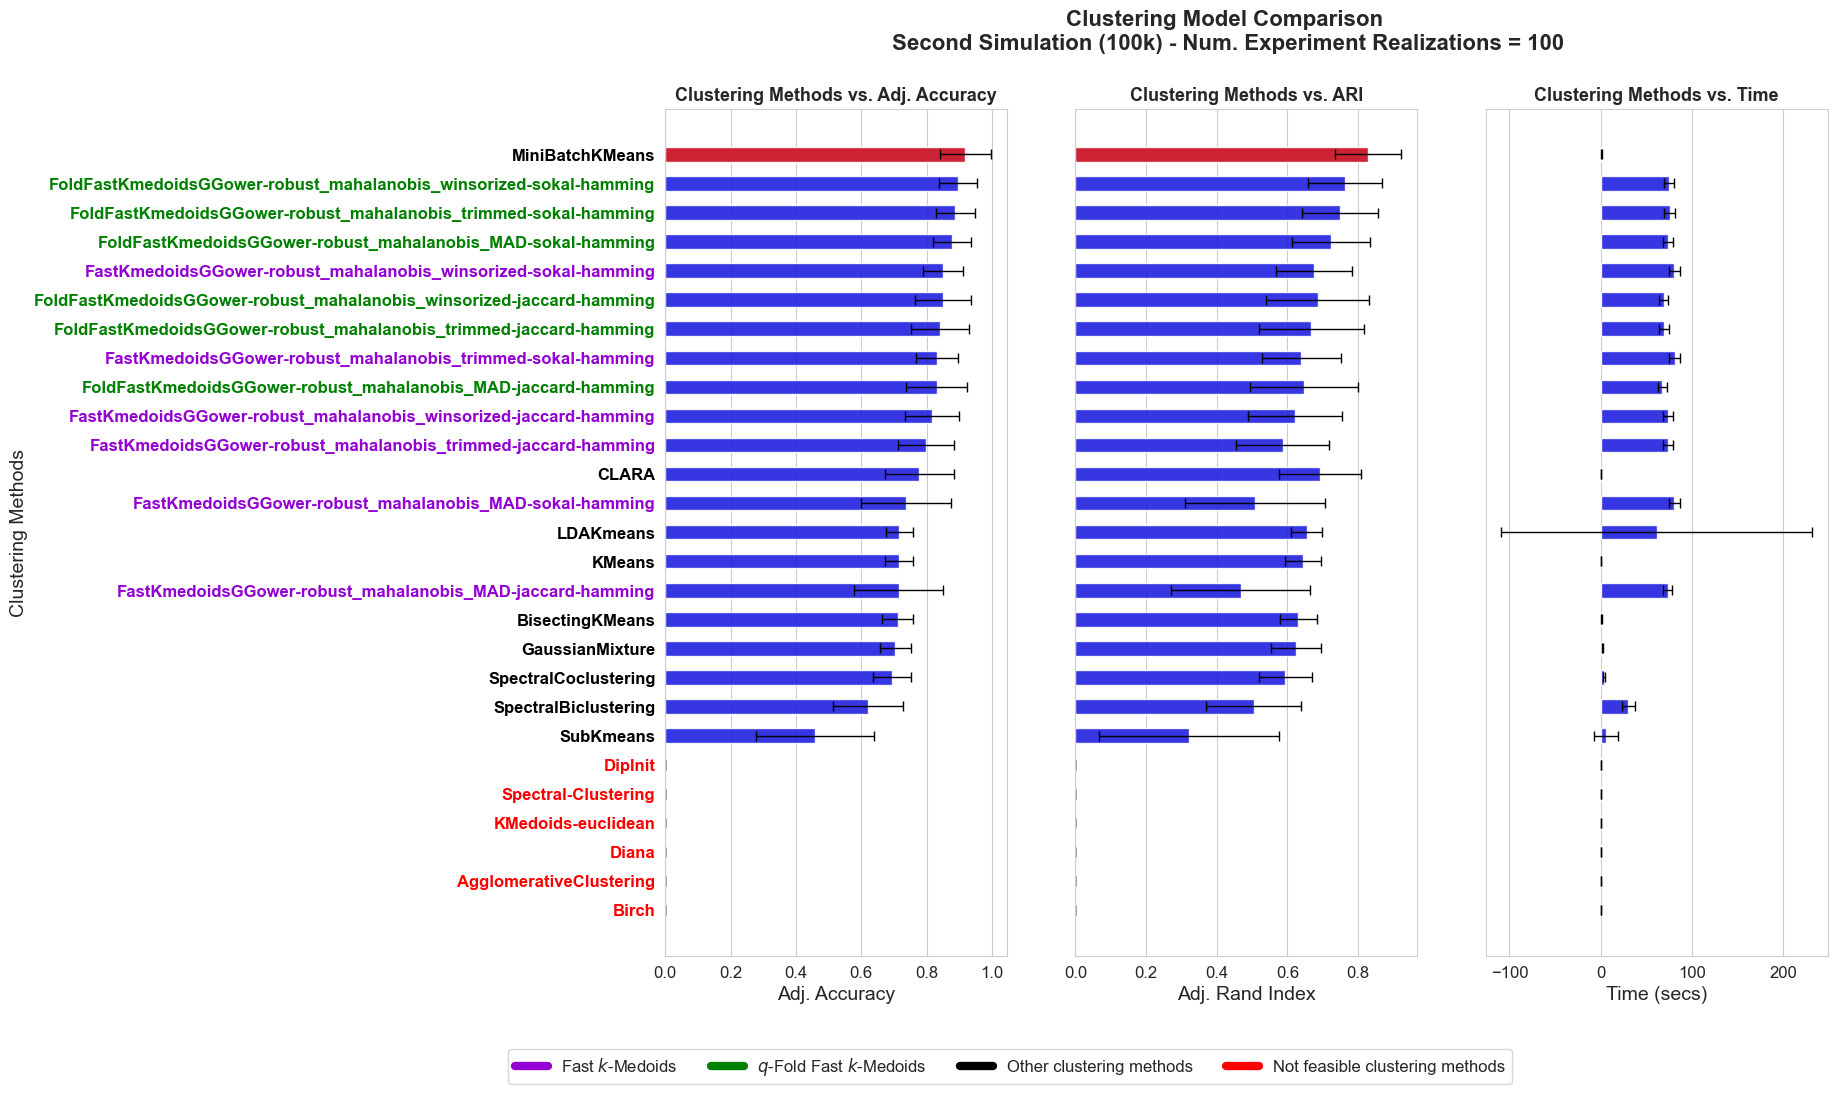

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

# Añadir barras de error manualmente
axes[0].errorbar(
    x=avg_adj_accuracy[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_adj_acc[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[1].errorbar(
    x=avg_ari[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_ari[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[2].errorbar(
    x=avg_time[idx_sorted],
    y=np.arange(len(model_names[idx_sorted])),
    xerr=std_time[idx_sorted],
    fmt='none',                # no dibuja puntos extra
    ecolor='black',            # color de las líneas de error
    elinewidth=1,            # grosor de las líneas
    capsize=3.5,                 # tamaño de los topes
    alpha=1
)

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison \nSecond Simulation (100k) - Num. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_simu_3_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [16]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [ ]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
MiniBatchKMeans,0.737116,0.918194,0.828652
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,75.222789,0.895598,0.763689
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,75.704642,0.888146,0.748822
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,73.897386,0.876719,0.723322
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,80.736637,0.850926,0.675541
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,68.985627,0.849957,0.685922
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,68.969163,0.840371,0.667988
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,80.792918,0.832377,0.639986
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,67.279021,0.830107,0.647321


In [ ]:
avg_results_df_sorted_ari

,time,adj_accuracy,ARI
models,,,
MiniBatchKMeans,0.737116,0.918194,0.828652
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,75.222789,0.895598,0.763689
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,75.704642,0.888146,0.748822
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,73.897386,0.876719,0.723322
CLARA,0.255702,0.777542,0.691619
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,68.985627,0.849957,0.685922
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,80.736637,0.850926,0.675541
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,68.969163,0.840371,0.667988
LDAKmeans,61.245868,0.716295,0.654377


### MDS visualization

In [ ]:
random_state_mds = 6863

X, y, outliers_idx = get_simulation_3(random_state=random_state_mds, return_outlier_idx=True)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.02, random_state=random_state_mds, p1=4, p2=2, p3=2, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

/home/fabio/fabio_scielzo_ortiz/tasks/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [23]:
outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'CLARA']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}


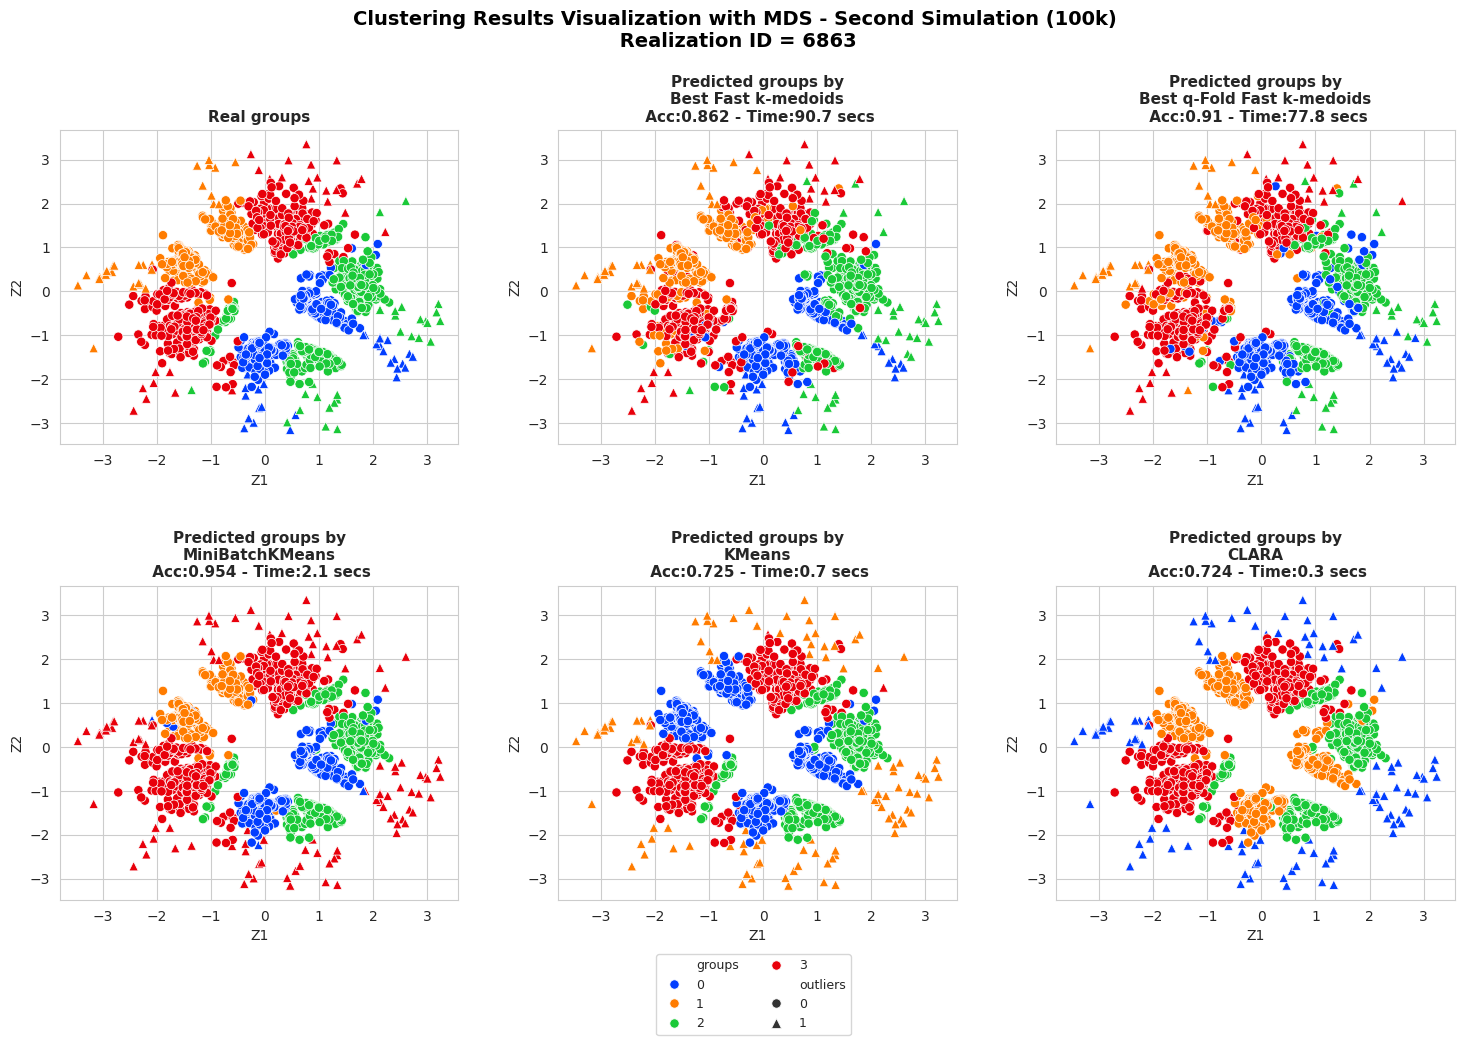

In [25]:
plot_filename = f'mds_plot_exp_4_simu_3_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', 'results', 'results_experiment_4', 'simulation_2')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Second Simulation (100k)\n Realization ID = {random_state_mds}", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=14, title_weight='bold', 
                                     subtitles_size=11,
                                     points_size=45, title_height=1, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='', legend_size=9, 
                                     save = True, file_name = plot_save_path
)